In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sys
sys.path.insert(0, '../..')
from scripts.utils.latex import add_colname, show_latex, TABLES

In [2]:
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', None)

# Load data

In [3]:
path = Path('../../data/expr_july')

In [4]:
# load core team annotations; pickles are deduplicated during processing
annot = pd.concat([pd.read_pickle(fp) for fp in path.glob('*_dedup.pkl')], ignore_index=True)

# load ze annotations and remove IAA files
ze = pd.concat(
    [pd.read_pickle(fp) for fp in path.glob('annotated_df_ze_*.pkl')], ignore_index=True
).query("~NotitieID.isin(@annot.NotitieID)")

# concat
df = pd.concat([annot, ze], ignore_index=True).assign(
    disregard_note = lambda df: df.groupby('NotitieID').disregard.transform('max'),
)

In [5]:
# load batch info
path = Path('../../data/to_inception_conll')
info = pd.concat([pd.read_pickle(fp) for fp in path.glob('week_*.pkl')], ignore_index=True)

In [6]:
df = df.merge(
    info[['NotitieID', 'MDN', 'source', 'samp_meth']],
    how='left',
    on=['NotitieID', 'MDN'],
)

# Annotated notes

In [7]:
caption = "Weeks 14-26: Number of annotated notes (incl. disregard)"
label = "w14-w26_annot_n_notes"

df.pivot_table(
    index='source',
    values='NotitieID',
    aggfunc='nunique',
    margins=True,
    margins_name='total',
).rename(columns={'NotitieID': 'n_notes'}
).join(
        df.query("disregard == True").pivot_table(
        index='source',
        values='NotitieID',
        aggfunc='nunique',
        margins=True,
        margins_name='total',
    ).rename(columns={'NotitieID': 'n_disregard'})
).assign(
    n_annotated=lambda df: df.n_notes - df.n_disregard,
    prc_disregard=lambda df: (df.n_disregard / df.n_notes).mul(100).round(1),
).pipe(show_latex, caption=caption, label=label)

,n_notes,n_disregard,n_annotated,prc_disregard
source,,,,
2017,976,130,846,13.3
2018,939,129,810,13.7
cov_2020,"1,886",54,"1,832",2.9
non_cov_2020,992,170,822,17.1
total,"4,793",483,"4,310",10.1


# Annotated sentences

In [8]:
# remove "disregard" notes & remove MBW annotations from week 14
adjusted = df.query("disregard_note != True").assign(
    MBW = lambda df: df.MBW.mask(df.batch == 'week_14', other=False),
    MBW_lvl = lambda df: df.MBW_lvl.mask(df.batch == 'week_14'),
)

# select rows with domain labels
domains = ['ENR', 'ATT', 'STM', 'ADM', 'INS', 'MBW', 'FAC', 'BER', 'ETN']
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['source', 'sen_id'])[domains].any()

In [9]:
caption = "Weeks 14-26: Number of sentences with domain labels (excl. disregard)"
label = "w14-w26_annot_sents_w_domain_labels"

n_sent = adjusted.groupby('source').sen_id.nunique()

n_sent_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('source').sen_id.nunique()

table = pd.concat([
    n_sent.rename('n_all_sents'),
    n_sent_with_label.rename('n_sents_with_labels'),
], axis=1)
table.loc['total'] = table.sum()
table.assign(prc_sents_with_labels=lambda df: (df.n_sents_with_labels / df.n_all_sents).mul(100).round(1)
).pipe(show_latex, caption=caption, label=label)

,n_all_sents,n_sents_with_labels,prc_sents_with_labels
source,,,
2017,"39,246","1,894",4.8
2018,"39,469","1,786",4.5
cov_2020,"96,568","6,377",6.6
non_cov_2020,"43,159","1,742",4.0
total,"218,442","11,799",5.4


# Distribution of domains

In [10]:
caption = "Weeks 14-26: Distribution of domains"
label = "w14-w26_annot_domains"

n_labels = domain_totals_per_sen_id.pivot_table(
    index='source',
    values=domains,
    aggfunc='sum',
    margins=True,
    margins_name='total',
).assign(total=lambda df: df.sum(axis=1))

p_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round()

piv = n_labels.pipe(add_colname, 'n').join(
    p_labels.pipe(add_colname, '%')
).astype('Int64'
).sort_index(axis=1, level=[0,1], ascending=[True, False])

piv.pipe(show_latex, caption=caption, label=label)

ADM      ATT     BER     ENR       ETN        FAC        INS  \
                  n   %    n  %    n  %    n  %      n   %      n   %      n   
source                                                                         
2017            401  20   48  2   49  2  165  8    454  22    208  10    165   
2018            438  23   31  2   57  3  137  7    434  23    240  12    193   
cov_2020      3,079  45  131  2   85  1  504  7  1,116  16    477   7    610   
non_cov_2020    494  27   46  2   46  2  143  8    326  18    188  10    180   
total         4,412  35  256  2  237  2  949  8  2,330  18  1,113   9  1,148   

                  MBW        STM       total       
               %    n   %      n   %       n    %  
source                                             
2017           8  219  11    333  16   2,042  100  
2018          10  152   8    240  12   1,922  100  
cov_2020       9  274   4    535   8   6,811  100  
non_cov_2020  10  119   6    310  17   1,852  100  
total          9  764   6  1,418  11  12,627  100

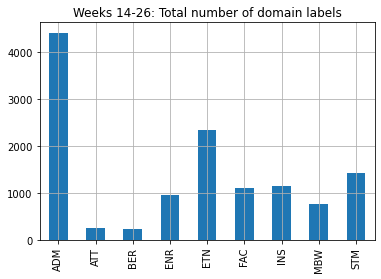

In [11]:
# total number of labels

fig, ax = plt.subplots(figsize=(6, 4))
piv.loc[['total']].xs('n', axis=1, level=1).iloc[:,:-1].T.plot.bar(
    ax=ax,
    legend=False, 
    grid=True, 
    title='Weeks 14-26: Total number of domain labels',
)
fig.savefig('figures/w14-w26_total_n_domains.png')

# Distribution of levels per domain

In [12]:
caption = "Weeks 14-26: Distribution of levels per domain"
label = "w14-w26_annot_levels"

stats = []
for lvl in [f"{i}_lvl" for i in domains]:
    notna = adjusted.loc[adjusted[lvl].notna()]
    stat = notna.groupby(['source', 'sen_id'])[lvl].apply(lambda s: {i for i in s if i==i})
    stat = stat.explode().groupby(level=0).value_counts()
    stats.append(stat)
table = pd.concat(stats, axis=1)
table = table.append(pd.concat([table.groupby(level=1).sum()], keys=['total']))
table.index = pd.MultiIndex.from_tuples([(i,int(j)) for i,j in table.index])
# sums = table.groupby(level=0).sum()
# sums.index = pd.MultiIndex.from_tuples([(i, 'total') for i in sums.index])
# table = pd.concat([table, sums]).sort_index(level=0)
table.pipe(show_latex, caption=caption, label=label)

ENR_lvl ATT_lvl STM_lvl  ADM_lvl INS_lvl MBW_lvl FAC_lvl  \
2017         0     4.0     nan    23.0     41.0       6     3.0      14   
             1    37.0     1.0    50.0     58.0      34    37.0       7   
             2    97.0    20.0   136.0     72.0      49    80.0      13   
             3    20.0     5.0    65.0     86.0      42    48.0      21   
             4     7.0    23.0    79.0    186.0      13    57.0     136   
             5     nan     nan     nan      nan      27     nan      24   
2018         0     3.0     3.0     2.0     19.0       4     2.0       5   
             1    37.0     6.0    37.0     61.0      31    38.0       7   
             2    79.0     8.0   102.0     82.0      59    49.0      23   
             3    10.0     3.0    46.0    112.0      52    24.0      20   
             4     9.0    12.0    58.0    203.0      22    42.0     157   
             5     nan     nan     nan      nan      35     nan      42   
cov_2020     0    28.0     6.0    29.0    664.0      57     7.0      61   
             1   172.0    14.0    70.0    971.0     212    82.0      25   
             2   250.0    67.0   238.0    562.0     194    68.0      23   
             3    43.0    16.0    91.0    576.0     119    38.0      90   
             4    22.0    33.0   136.0    589.0      32    80.0     248   
             5     nan     nan     nan      nan      21     nan      42   
non_cov_2020 0    10.0     4.0    16.0     19.0       9     5.0      25   
             1    39.0     7.0    60.0     89.0      49    28.0       5   
             2    75.0    23.0   125.0     94.0      54    26.0      10   
             3    13.0     5.0    57.0    101.0      35    23.0      30   
             4    17.0     7.0    64.0    248.0      20    38.0     111   
             5     nan     nan     nan      nan      27     nan      13   
total        0    45.0    13.0    70.0    743.0      76    17.0     105   
             1   285.0    28.0   217.0  1,179.0     326   185.0      44   
             2   501.0   118.0   601.0    810.0     356   223.0      69   
             3    86.0    29.0   259.0    875.0     248   133.0     161   
             4    55.0    75.0   337.0  1,226.0      87   217.0     652   
             5     0.0     0.0     0.0      0.0     110     0.0     121   

               BER_lvl ETN_lvl  
2017         0    10.0    45.0  
             1     1.0   180.0  
             2     5.0   135.0  
             3     7.0    38.0  
             4    26.0    79.0  
             5     nan     nan  
2018         0     9.0    49.0  
             1     3.0   160.0  
             2    12.0   134.0  
             3     1.0    34.0  
             4    32.0    76.0  
             5     nan     nan  
cov_2020     0    31.0   225.0  
             1     3.0   261.0  
             2    16.0   412.0  
             3     6.0    98.0  
             4    31.0   176.0  
             5     nan     nan  
non_cov_2020 0    15.0    27.0  
             1     3.0    87.0  
             2     7.0    92.0  
             3     2.0    46.0  
             4    17.0    92.0  
             5     nan     nan  
total        0    65.0   346.0  
             1    10.0   688.0  
             2    40.0   773.0  
             3    16.0   216.0  
             4   106.0   423.0  
             5     0.0     0.0

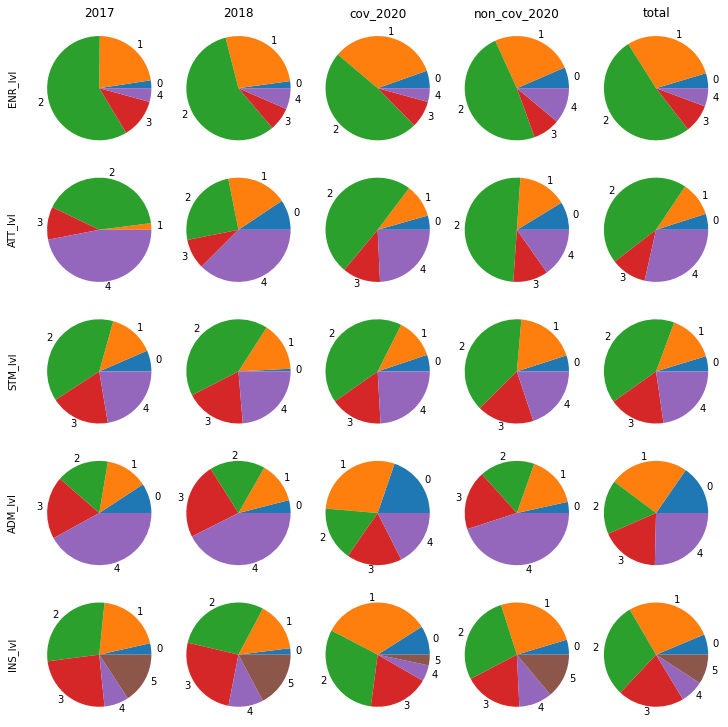

In [13]:
cols = table.index.levels[0]
rows = table.columns[:5]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w26_levels_part1.png')

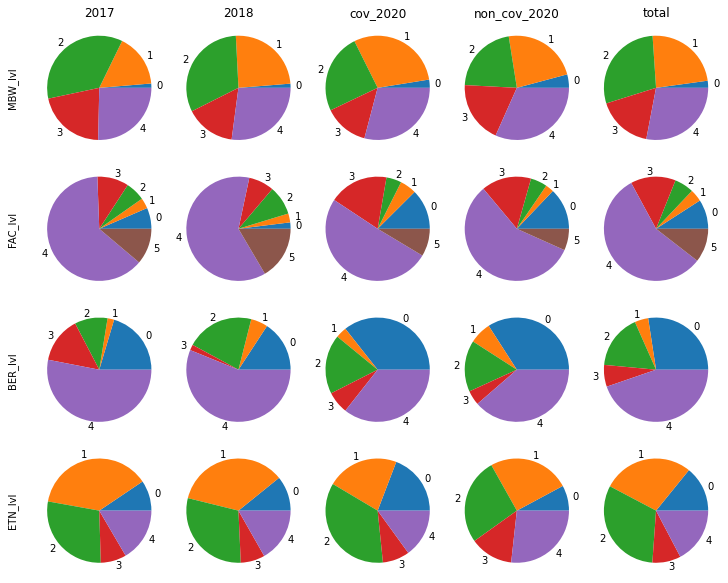

In [14]:
cols = table.index.levels[0]
rows = table.columns[5:]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ylabel = row if j == 0 else ''
        table.xs(col)[row].plot.pie(ax=axes[i,j])
        axes[i,j].set_ylabel(ylabel=ylabel, labelpad=16)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

fig.savefig('figures/w14-w26_levels_part2.png')

# Randomly-selected notes vs. Keyword-selected notes

In [15]:
# % disregard notes (out of all notes)
compare_samp = df.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
).groupby(['samp_meth']).apply(
    lambda grp: grp.groupby('NotitieID').disregard_note.first().agg({'n':'size', 'p':'sum'})
)
pct_disregard = (compare_samp.p / compare_samp.n).mul(100).round(1).rename(r'% disregard notes')

# % sentences with labels (out of all sents, excl. disregard)
adjusted = adjusted.assign(
    samp_meth=lambda df: df.samp_meth.str.split('_').str[0]
)
n_sents = adjusted.groupby('samp_meth').sen_id.nunique()

n_sents_with_label = adjusted.assign(
    has_domain = lambda df: df[domains].any(axis=1),
).query("has_domain == True").groupby('samp_meth').sen_id.nunique()

pct_sents_with_label = (n_sents_with_label / n_sents).mul(100).round(1).rename(r'% sentences with labels')

# distribution of domains
rows_with_domain = adjusted.loc[adjusted[domains].any(axis=1)]
domain_totals_per_sen_id = rows_with_domain.groupby(['samp_meth', 'sen_id'])[domains].any()

n_labels = domain_totals_per_sen_id.pivot_table(
    index='samp_meth',
    values=domains,
    aggfunc='sum',
).assign(total=lambda df: df.sum(axis=1))

pct_labels = (n_labels.div(n_labels.iloc[:, -1], axis=0) * 100).round(1).iloc[:,:-1]

# put everything together
caption = "Weeks 14-26: Comparison between randomly-selected and keyword-selected notes"
label = "w14-w26_annot_kwd_vs_rndm"

pd.concat([pct_disregard, pct_sents_with_label, pct_labels], axis=1).T.pipe(show_latex, caption=caption, label=label)

samp_meth,kwd,rndm
% disregard notes,10.7,8.2
% sentences with labels,5.4,5.1
ADM,34.9,35.1
ATT,2.2,1.0
BER,1.9,2.0
ENR,7.7,6.3
ETN,18.0,21.3
FAC,8.6,10.0
INS,9.2,8.3
MBW,6.2,5.2


In [16]:
prefix = 'w14-w26_annot'
for idx, table in enumerate(TABLES):
    with open(f'./tables/{prefix}_{idx}.tex', 'w', encoding='utf8') as f:
        f.write(table)